# OECD/SWAC Africapolis with urban green space indicators

## Background

[Africapolis](https://africapolis.org/en) is a dataset designed by the [Sahel and West Africa Club](https://www.oecd.org/swac/) to provide a much needed standardised and geospatial database on urbanisation dynamics in Africa, with the aim of making urban data in Africa comparable across countries and across time. The first version of Africapolis (circa 2015) was the first time that the data for the 54 countries currently covered was available for the same base year. In addition, Africapolis closes one major data gap by integrating small towns and intermediary cities between 10,000 and 300,000 inhabitants. The second version is an update for the reference year 2020.

Africapolis data is based on a large inventory of housing and population censuses, electoral registers and other official population sources, in some cases dating back to the beginning of the 20th century. While essential for building any database, the regularity, the detail and the reliability of these sources vary from country to country, and from period to period. Census data or official population records are often more than 10 years old and, in certain cases, go back 30 or more years. Given the pace of demographic and urban change these are significant periods.

Satellite and aerial images are used to fill in and complete the gaps and inconsistencies in official records, by capturing the physical evidence on the ground, that is the built-up area and the precise location of settlements. Other official cartographic resources, such as administrative boundaries, are also used to link population data to observed information on the built-up areas.

The teams working on Africapolis, at e-Geopolis and at the OECD Sahel and West Africa Club, have worked for years to build the Africapolis database, learning during the process, adding new sources and improving on the tools and methodology used to make the data as precise as possible.

Africapolis will remain an ongoing endeavour, providing data and evidence to support cities and governments to make urban areas more inclusive, productive and sustainable. These datasets (``Africapolis_2015`` and ``Africapolis_2020``) are shared with indicators or urban green space, i.e., the percentage of the urban agglomeration area that has green cover (trees, shrubs, and grass), as well as the percentage of tree cover. Green spaces deliver ecosystem services that boost cities’ resilience to climate change and strengthen their sustainability. They can attenuate the impacts of extreme weather events such as heat waves, heavy rainfalls, storms and floods, as well as slow-onset risks like drought, land erosion, and landslides. The urban green space indicators were estimated using the land cover information from the [ESA World Cover v100 (2020)]("https://worldcover2020.esa.int/") and [ESA World Cover v200 (2021)](https://worldcover2021.esa.int/) datasets.

The indicators joined to the Africapolis datasets provide policymakers and city authorities with a reference baseline to keep track of the progress toward more resilient urban areas. 

Information about green spaces and urban form indicators is also available on the Mapping Territorial Transformations in Africa (MAPTA) platform: www.mapping-africa-transformations.org/climate
For demographic information related to urban agglomerations, please visit Africapolis.org

## Suggested citations: 
Please cite the use of these datasets as follows:  
OECD/SWAC (2024), Africapolis (database), www.africapolis.org (accessed yyyy-mm-dd). 
OECD/SWAC (2024) Urban green space indicators, www.mapping-africa-transformations.org/climate (accessed yyyy-mm-dd).  

### Description
This notebook demostrates how to load and visualise the OECD SWAC Africapolis agglomerations.
The notebook covers:
1. Getting a list of available polygons in a given area
2. Select and plot a single polygon and its urban green space indicators

## Getting started

To run this analysis, run all the cells in the notebook, starting with the “Load packages” cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import box
from odc.geo.geom import Geometry
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.plotting import display_map, plot_lulc
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.load_africapolis import get_africapolis

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Africapolis")

### Analysis parameters
#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers an area around Kumasi in southern Ghana.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=6.6975, lon=-1.6286, buffer=0.2)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(x=lon_range, y=lat_range)

## Loading urban agglomeration from Africapolis
The `load_africapolis` module allows you to query the OECD SWAC Africapolis urban agglomerations from the Geoserver. There are two layers available: `Africapolis_2015` and `Africapolis_2020`, representing urban agglomeration data for those respective years.


By using the `get_africapolis` function, you can retrieve a list of urban agglomeration polygons (which include indicators for urban green space and tree cover) within a bounding box defined by the area of interest (which is set in the earlier cell).

For example, the following code will load the urban agglomerations for 2020 from the ``Africapolis_2020`` layer within the defined bounding box:

In [4]:
# Create a bounding box from study area coordinates
bbox = (lon_range[0], lat_range[0], lon_range[1], lat_range[1])

# Load Africapolis data. 
agglomerations = get_africapolis(bbox=bbox, layer='Africapolis_2020')

# Print list of urban agglomerations and their green urban green space indicators
agglomerations.head()

,id,agglosID,agglosName,ISO3,Pop2020,p_Urban_green_space_WC2020,p_Tree_cover_WC2020,p_Urban_green_space_WC2021,p_Tree_cover_WC2021,Longitude,Latitude,color_HEX,geometry
0,Africapolis_2020.5112,5112,Kumasi,GHA,2436114,40.1,18.5,42.3,20.7,-1.624333,6.670937,#f1b78c,"MULTIPOLYGON (((-1.8533 6.658, -1.8533 6.658, ..."
1,Africapolis_2020.6975,6975,Offinso,GHA,59753,54.3,24.5,58.2,25.9,-1.681305,6.949271,#a02f3f,"MULTIPOLYGON (((-1.6485 6.8994, -1.6483 6.8997..."
2,Africapolis_2020.11073,11073,Ankaase,GHA,13557,60.3,40.4,66.8,39.9,-1.558112,6.845862,#602317,"MULTIPOLYGON (((-1.5721 6.8498, -1.5721 6.8497..."
3,Africapolis_2020.11947,11947,Barekese,GHA,10700,60.2,32.7,61.3,38.7,-1.731679,6.850784,#602317,"MULTIPOLYGON (((-1.756 6.8637, -1.756 6.8637, ..."
4,Africapolis_2020.12047,12047,Foase kokoben,GHA,10525,66.4,34.3,68.0,46.0,-1.748245,6.632355,#602317,"MULTIPOLYGON (((-1.7611 6.6359, -1.7611 6.6359..."


### Displaying ruban agglomeration polygons
Once the urban agglomeration polygons are loaded into memory, you can visualize them using static plots or explore them interactively in a map viewer for more detailed examination. The color scheme is assigned according to the urban agglomeration's population size.

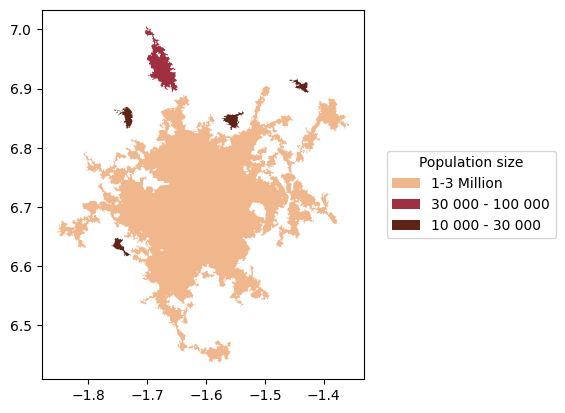

In [5]:
# Predefined labels and colors
legend_labels = [
    ('Above 3 Million', '#f8dca0'),
    ('1-3 Million', '#f1b78c'),
    ('300 000 - 1 Million', '#e38479'),
    ('100 000 - 300 000', '#cb5260'),
    ('30 000 - 100 000', '#a02f3f'),
    ('10 000 - 30 000', '#602317')
]

# Filter agglomerations by available colors
unique_colors = agglomerations['color_HEX'].unique()

# Generate legend elements for only the available colors
legend_elements = []
for label, color in legend_labels:
    if color in unique_colors:
        legend_elements.append(Patch(facecolor=color, label=label))

# Plot your agglomerations
agglomerations.plot(color=agglomerations['color_HEX'])
# Add a custom legend
plt.legend(handles=legend_elements, title="Population size", loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.show()


In [6]:
# Explore the urban agglomeration polygons located within the bounding box
agglomerations.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                       color=agglomerations['color_HEX'],
                       attr='http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}')

### Urban green space indicators for a single urban agglomeration
Visualize the urban green space indicators for one agglomeration, showing its map with population and a bar chart comparing the percentage of urban green space and tree cover for 2020 and 2021.

***These indicators were estimated using the land cover information from the [ESA World Cover v100 (2020)]("https://worldcover2020.esa.int/") and [ESA World Cover v200 (2021)](https://worldcover2021.esa.int/) datasets.***

In [7]:
# Edit the name below to select the area of interest
region_name = "Kumasi"
selected_agglomeration = agglomerations[agglomerations["agglosName"] == region_name]
selected_agglomeration

,id,agglosID,agglosName,ISO3,Pop2020,p_Urban_green_space_WC2020,p_Tree_cover_WC2020,p_Urban_green_space_WC2021,p_Tree_cover_WC2021,Longitude,Latitude,color_HEX,geometry
0,Africapolis_2020.5112,5112,Kumasi,GHA,2436114,40.1,18.5,42.3,20.7,-1.624333,6.670937,#f1b78c,"MULTIPOLYGON (((-1.8533 6.658, -1.8533 6.658, ..."


Next, create a figure with two subplots: one showing the map of Kumasi and another showing the bar chart comparing the urban green space and tree cover for 2020 and 2021. Additionally, include the ESA WorldCover 2020 and 2021 datasets, highlighting the spatial distribution of urban green space, tree cover, and other land cover categories within the selected agglomeration.

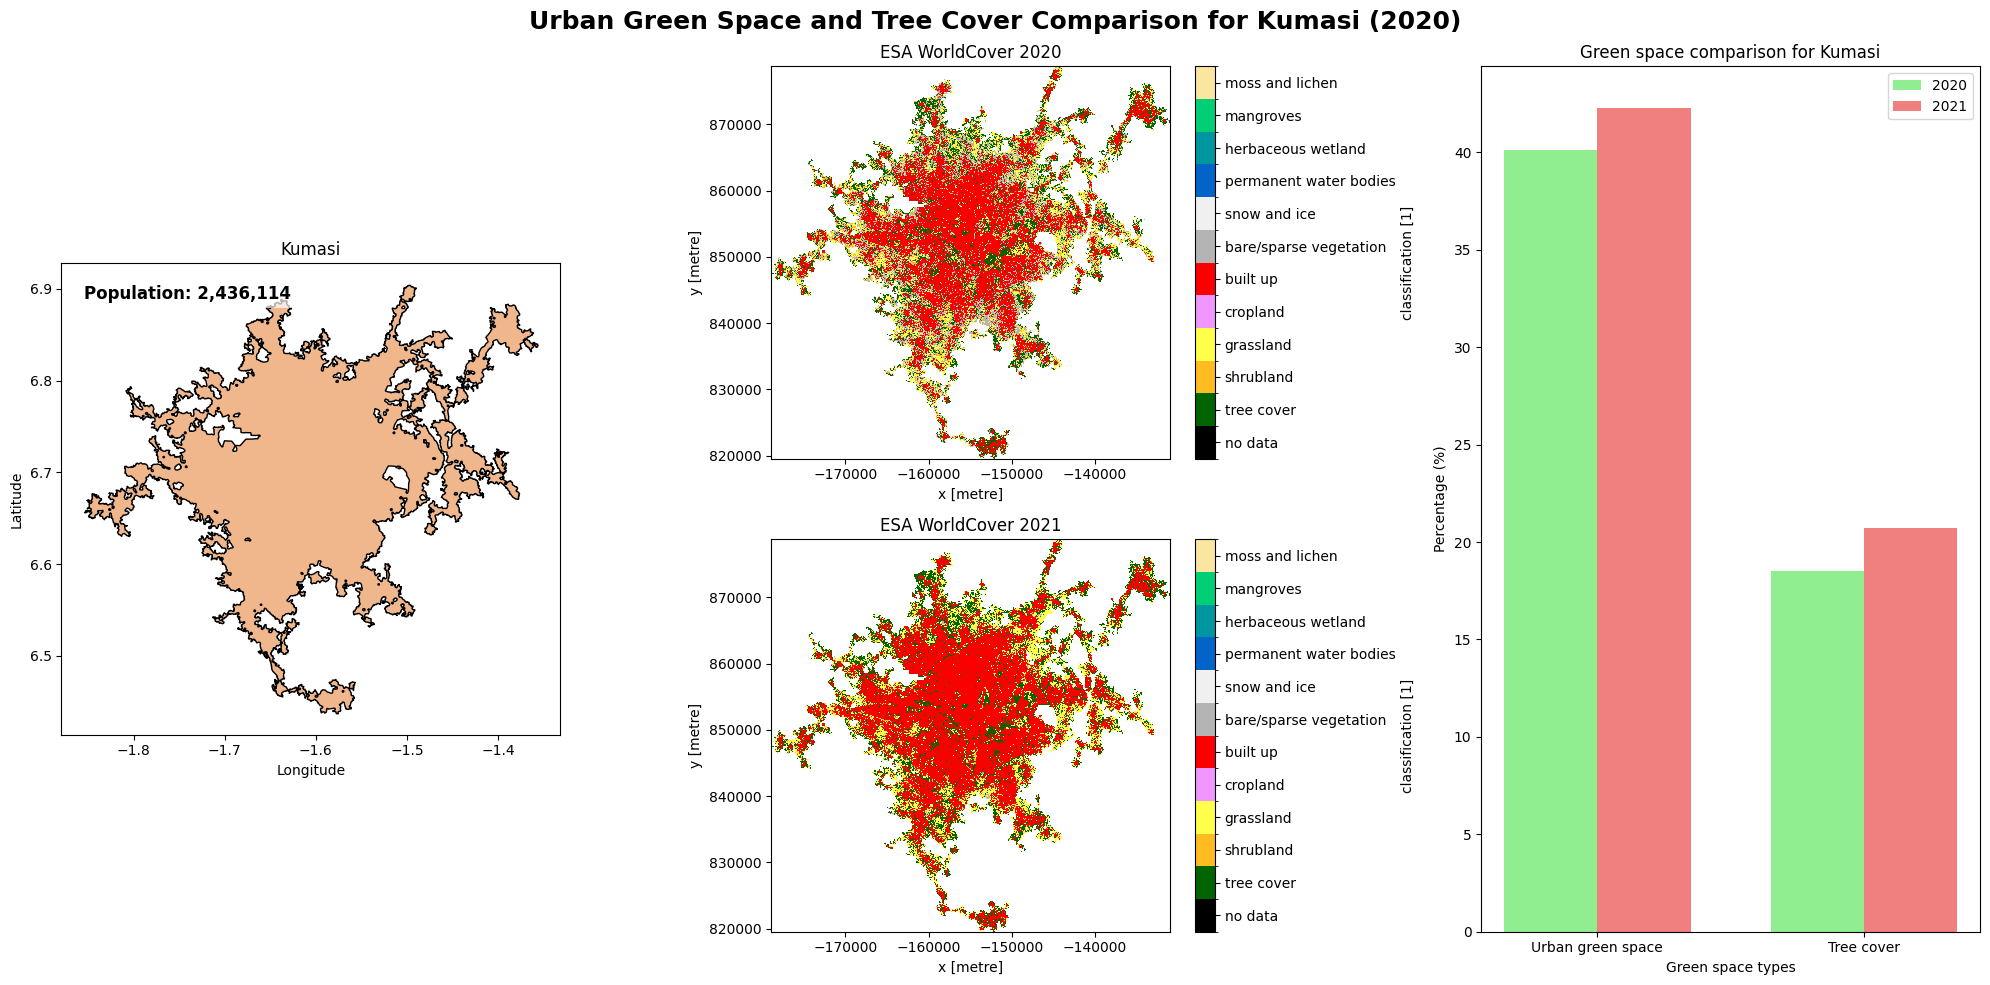

In [8]:
# Load ESA Worldcover 2020 and 2021
query = {
    'y': (selected_agglomeration.total_bounds[1], selected_agglomeration.total_bounds[3]),
    'x': (selected_agglomeration.total_bounds[0], selected_agglomeration.total_bounds[2]),
    'resolution':(10,-10),
    'output_crs': 'epsg:6933',
    'measurements':'classification'
}
#load the data
esa_wc = dc.load(product=['esa_worldcover_2020', 'esa_worldcover_2021'], **query).squeeze()
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=selected_agglomeration,
                          da=esa_wc,
                          crs=esa_wc.crs)
#Mask the dataset to the rasterised area of interest
esa_wc = esa_wc.where(aoi_raster == 1)


# Create a figure with a grid layout for customized positioning
fig = plt.figure(figsize=(20, 10))

# Add subplots to the grid
ax_map = plt.subplot2grid((2, 3), (0, 0), rowspan=2)  # Map spans 2 rows
ax_wc2020 = plt.subplot2grid((2, 3), (0, 1))          # WorldCover 2020 in the middle
ax_wc2021 = plt.subplot2grid((2, 3), (1, 1))          # WorldCover 2021 below the 2020
ax_bar = plt.subplot2grid((2, 3), (0, 2), rowspan=2)  # Bar chart spans 2 rows on the right

# Plot the selected agglomeration polygon on the map axis
selected_agglomeration.plot(ax=ax_map, color=selected_agglomeration['color_HEX'], edgecolor='black')
ax_map.set_title(f"{selected_agglomeration['agglosName'].iloc[0]}")
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# Get the top-left corner of the bounding box
bbox = selected_agglomeration.total_bounds
top_left_x, top_left_y = bbox[0], bbox[3]

# Automatically detect the population column based on the column name starting with "Pop"
pop_column = [col for col in selected_agglomeration.columns if col.startswith('Pop')][0]
pop_label = selected_agglomeration[pop_column].iloc[0]

# Add population label to the map
ax_map.text(
    top_left_x, top_left_y, f"Population: {pop_label:,}",
    fontsize=12, 
    fontweight='bold',  
    ha='left', va='top',  
    color='black',  
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)) 

# Data for the bar chart
labels = ['Urban green space', 'Tree cover']
wc2020 = [
    selected_agglomeration['p_Urban_green_space_WC2020'].iloc[0],
    selected_agglomeration['p_Tree_cover_WC2020'].iloc[0]
]
wc2021 = [
    selected_agglomeration['p_Urban_green_space_WC2021'].iloc[0],
    selected_agglomeration['p_Tree_cover_WC2021'].iloc[0]
]

# Bar chart width and position
bar_width = 0.35
index = np.arange(len(labels))  # Position of the bars on the x-axis

# Plotting the grouped bar chart
ax_bar.bar(index - bar_width/2, wc2020, bar_width, label='2020', color='lightgreen')
ax_bar.bar(index + bar_width/2, wc2021, bar_width, label='2021', color='lightcoral')
ax_bar.set_xlabel('Green space types')
ax_bar.set_ylabel('Percentage (%)')
ax_bar.set_title(f"Green space comparison for {selected_agglomeration['agglosName'].iloc[0]}")
ax_bar.set_xticks(index)
ax_bar.set_xticklabels(labels)
ax_bar.legend()

# Plot ESA WorldCover 2020
lulc_2020 = esa_wc.sel(time="2020").squeeze()['classification']
plot_lulc(lulc_2020, product="ESA", legend=True, ax=ax_wc2020)
ax_wc2020.set_title("ESA WorldCover 2020")

# Plot ESA WorldCover 2021
lulc_2021 = esa_wc.sel(time="2021").squeeze()['classification']
plot_lulc(lulc_2021, product="ESA", legend=True, ax=ax_wc2021)
ax_wc2021.set_title("ESA WorldCover 2021")

# Automatically determine the year based on the loaded data (e.g., 2020 or 2015)
year = pop_column[-4:]  # Get the last 4 characters of the population column name
# Add a title for the entire figure
fig.suptitle(f"Urban Green Space and Tree Cover Comparison for {selected_agglomeration['agglosName'].iloc[0]} ({year})", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


### Urban green space indicators for multiple urban agglomeration
If you want to compare urban green space indicators for multiple agglomerations, the code below demonstrates how to display their maps and bar charts for urban green space and tree cover percentages in 2020 and 2021.

***These indicators were estimated using the land cover information from the [ESA World Cover v100 (2020)]("https://worldcover2020.esa.int/") and [ESA World Cover v200 (2021)](https://worldcover2021.esa.int/) datasets.***

In [9]:
# Select multiple agglomerations by name
select_regions = ["Kumasi", "Offinso"]
selected_agglomerations = agglomerations[agglomerations["agglosName"].isin(select_regions)]
selected_agglomerations

,id,agglosID,agglosName,ISO3,Pop2020,p_Urban_green_space_WC2020,p_Tree_cover_WC2020,p_Urban_green_space_WC2021,p_Tree_cover_WC2021,Longitude,Latitude,color_HEX,geometry
0,Africapolis_2020.5112,5112,Kumasi,GHA,2436114,40.1,18.5,42.3,20.7,-1.624333,6.670937,#f1b78c,"MULTIPOLYGON (((-1.8533 6.658, -1.8533 6.658, ..."
1,Africapolis_2020.6975,6975,Offinso,GHA,59753,54.3,24.5,58.2,25.9,-1.681305,6.949271,#a02f3f,"MULTIPOLYGON (((-1.6485 6.8994, -1.6483 6.8997..."


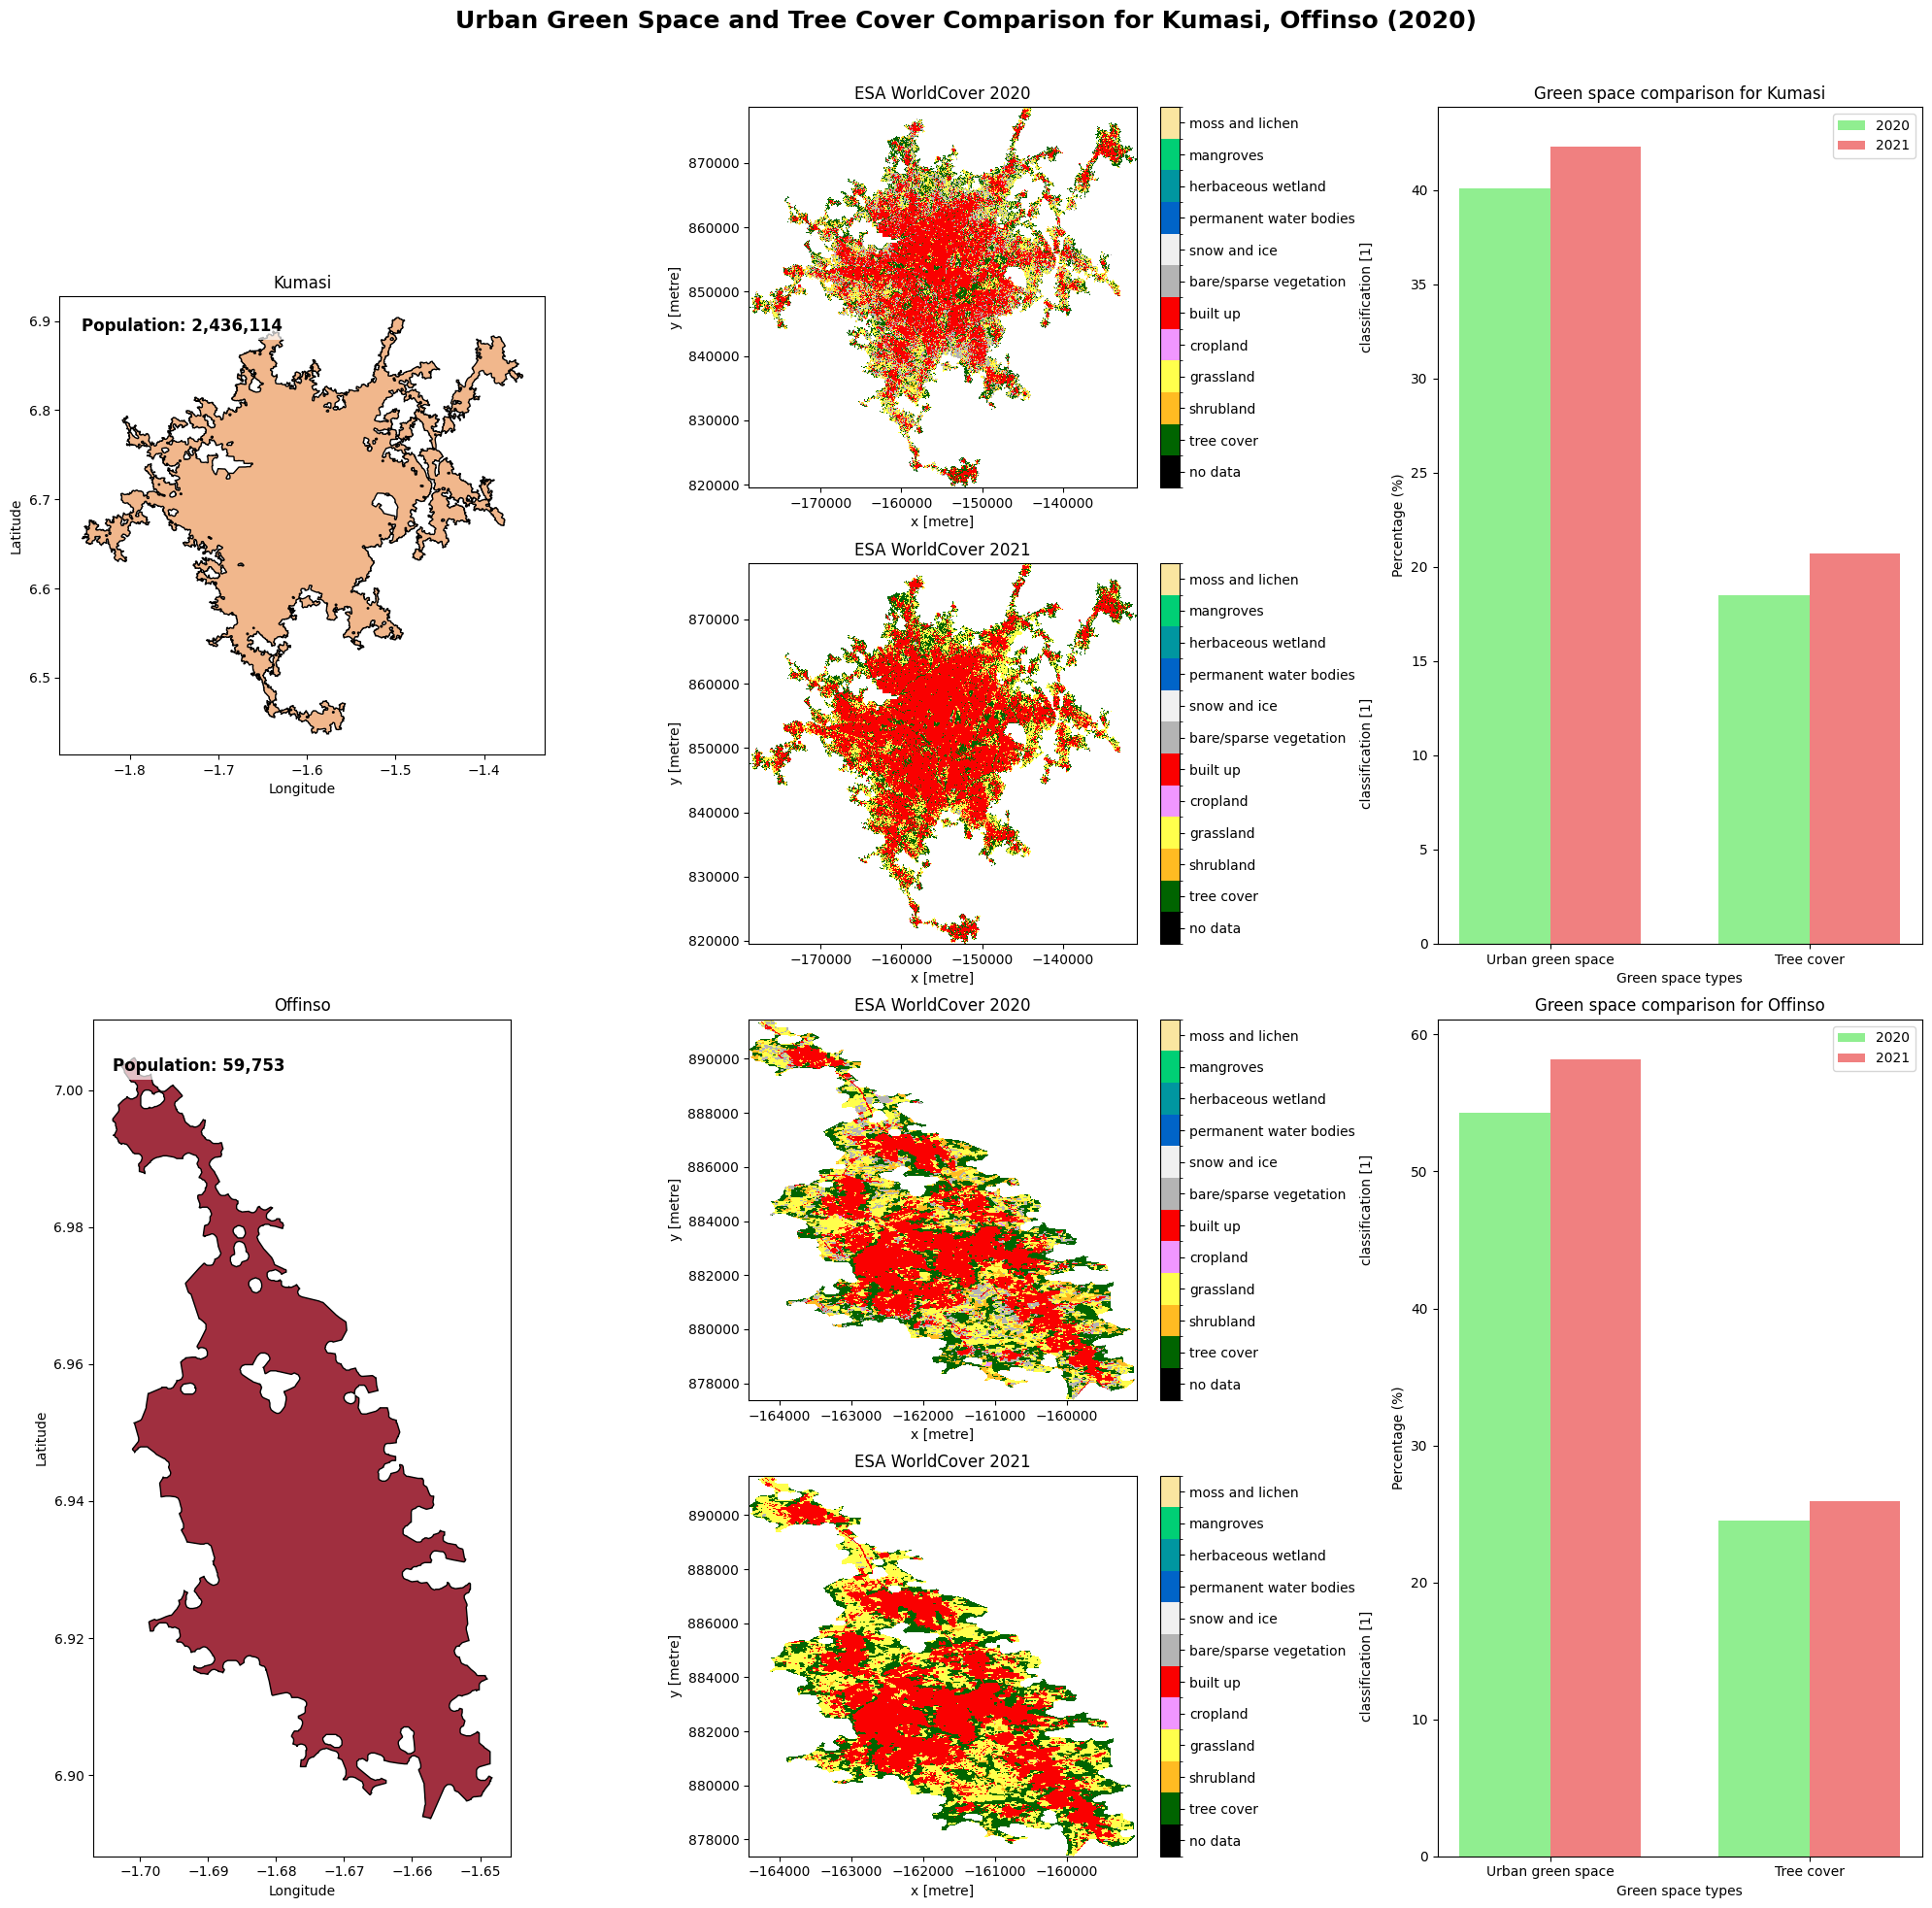

In [10]:
# Create a figure with dynamic subplots (3 columns: map, stacked WC, and bar)
num_agglomerations = len(selected_agglomerations)
fig = plt.figure(figsize=(20, 10 * num_agglomerations))  # Set figure size

# Iterate over selected agglomerations and their corresponding subplot axes
for i, (index, agglomeration) in enumerate(selected_agglomerations.iterrows()):
    # Subplot layout (3 columns: map, stacked WC, and bar)
    # Map subplot (spans 2 rows)
    ax_map = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2, 0), rowspan=2) 
    # ESA WorldCover 2020 (top half of the second column)
    ax_wc_2020 = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2, 1))  
    # ESA WorldCover 2021 (bottom half of the second column)
    ax_wc_2021 = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2 + 1, 1))  
    # Bar chart subplot (spans 2 rows)
    ax_bar = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2, 2), rowspan=2)
    # Extract the agglomeration as a GeoDataFrame
    agglomeration_gdf = selected_agglomerations.iloc[i:i+1]

    # Plot the agglomeration polygon on the map axis
    ax_map.set_title(f"{agglomeration['agglosName']}")
    agglomeration_gdf.plot(ax=ax_map, color=agglomeration['color_HEX'], edgecolor='black')
    ax_map.set_xlabel("Longitude")
    ax_map.set_ylabel("Latitude")
    
    # Get the top-left corner of the bounding box
    bbox = agglomeration_gdf.total_bounds
    top_left_x, top_left_y = bbox[0], bbox[3]
    
    # Automatically detect the population column (based on 'Pop' prefix)
    pop_column = [col for col in agglomeration_gdf.columns if col.startswith('Pop')][0]
    pop_label = agglomeration[pop_column]  # Get population dynamically

    # Add population label
    ax_map.text(
        top_left_x, top_left_y, f"Population: {pop_label:,}",
        fontsize=12,
        fontweight='bold',
        ha='left', va='top',
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
    
    # Prepare data for the bar chart
    labels = ['Urban green space', 'Tree cover']
    wc2020 = [
        agglomeration['p_Urban_green_space_WC2020'],
        agglomeration['p_Tree_cover_WC2020']
    ]
    wc2021 = [
        agglomeration['p_Urban_green_space_WC2021'],
        agglomeration['p_Tree_cover_WC2021']
    ]
    
    # Plot grouped bar chart
    bar_width = 0.35
    index = np.arange(len(labels))  # Position of the bars on the x-axis
    ax_bar.bar(index - bar_width/2, wc2020, bar_width, label='2020', color='lightgreen')
    ax_bar.bar(index + bar_width/2, wc2021, bar_width, label='2021', color='lightcoral')
    
    # Add labels and title to the bar chart
    ax_bar.set_xlabel('Green space types')
    ax_bar.set_ylabel('Percentage (%)')
    ax_bar.set_title(f"Green space comparison for {agglomeration['agglosName']}")
    ax_bar.set_xticks(index)
    ax_bar.set_xticklabels(labels)
    ax_bar.legend()

    # Load ESA WorldCover Data for each agglomeration
    query = {
        'y': (agglomeration_gdf.total_bounds[1], agglomeration_gdf.total_bounds[3]),
        'x': (agglomeration_gdf.total_bounds[0], agglomeration_gdf.total_bounds[2]),
        'resolution': (10, -10),
        'output_crs': 'epsg:6933',
        'measurements': 'classification'
    }
    
    # Load ESA WorldCover data for both 2020 and 2021
    esa_wc = dc.load(product=['esa_worldcover_2020', 'esa_worldcover_2021'], **query).squeeze()

    # Rasterize the area of interest polygon for masking ESA WorldCover data
    aoi_raster = xr_rasterize(gdf=agglomeration_gdf, da=esa_wc, crs=esa_wc.crs)

    # Mask ESA WorldCover data based on the agglomeration boundary
    esa_wc_2020_masked = esa_wc.sel(time="2020").squeeze()['classification'].where(aoi_raster == 1)
    esa_wc_2021_masked = esa_wc.sel(time="2021").squeeze()['classification'].where(aoi_raster == 1)

    # Plot ESA WorldCover 2020 (top part of the stack)
    plot_lulc(esa_wc_2020_masked, product="ESA", legend=True, ax=ax_wc_2020)
    ax_wc_2020.set_title("ESA WorldCover 2020")
    
    # Plot ESA WorldCover 2021 (bottom part of the stack)
    plot_lulc(esa_wc_2021_masked, product="ESA", legend=True, ax=ax_wc_2021)
    ax_wc_2021.set_title("ESA WorldCover 2021")

# Automatically determine the year based on the loaded data (e.g., "2020")
year = pop_column[-4:]  # Extract the year from the population column (e.g., "2015", "2020")

# Add a title for the entire figure
fig.suptitle(f"Urban Green Space and Tree Cover Comparison for {', '.join(selected_agglomerations['agglosName'].unique())} ({year})", fontsize=18, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.93) 
plt.show()


### **Interpreting the Final Plot**
The generated figure provides a comparative analysis of urban green space and tree cover within the selected agglomerations. Here’s how to interpret each component:

1. **Map view (first column)**
   - Displays the agglomeration boundary to provide spatial context.
   - Helps identify the extent of urban areas analysed for green space and tree cover.

2. **ESA WorldCover land cover (second column)**
   - Two stacked plots show the land cover classification for 2020 and 2021.
   - Any noticeable changes in green space or tree cover over time can be visually inspected.

3. **Bar chart comparison (third column)**
   - Shows the percentage of urban green space and tree cover in 2020 and 2021.
   - **Key observations:**
     - Increases indicate improvements in vegetation and potential reforestation efforts.
     - Decreases may suggest urban expansion, deforestation, or land-use changes.
     - Consistent values may indicate stable vegetation coverage.

### **Conclusions and recommendations**
This notebook demostrates how to load and visualise the OECD SWAC Africapolis agglomerations. For agglomerations that are not included in the Africapolis dataset, you can use the [Urban_green_space](../Real_world_examples/Urban_green_space.ipynb) notebook to replicate the analysis and obtain the necessary indicators. For more recent and finer-scale tree cover data, consider using the [Urban_tree_extent](Urban_tree_extent.ipynb) notebook, which utilizes DE Africa's Annual Sentinel-2 geomad to analyze annual tree cover changes, providing more recent insights than the ESA WorldCover datasets from 2020 and 2021.

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [11]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [12]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-01-31'